<a href="https://colab.research.google.com/github/maxi2321/MAXIABDALA/blob/main/Copia_de_final8_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_folder = '/content/drive/MyDrive/videos/train'

In [4]:
# Verificar si CUDA está disponible y configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## LECTURA DE DATOS

In [5]:
# vemos los archivos de audio
# carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase colectivo tiene 22 elementos
La clase camioneta tiene 18 elementos
La clase moto tiene 12 elementos
La clase silencio tiene 38 elementos
La clase auto tiene 37 elementos


In [6]:
print(sr)

48000


## ESPECTOGRAMAS CON STFT

Clase colectivo: 22 espectrogramas STFT
Clase camioneta: 18 espectrogramas STFT
Clase moto: 12 espectrogramas STFT
Clase silencio: 38 espectrogramas STFT
Clase auto: 37 espectrogramas STFT


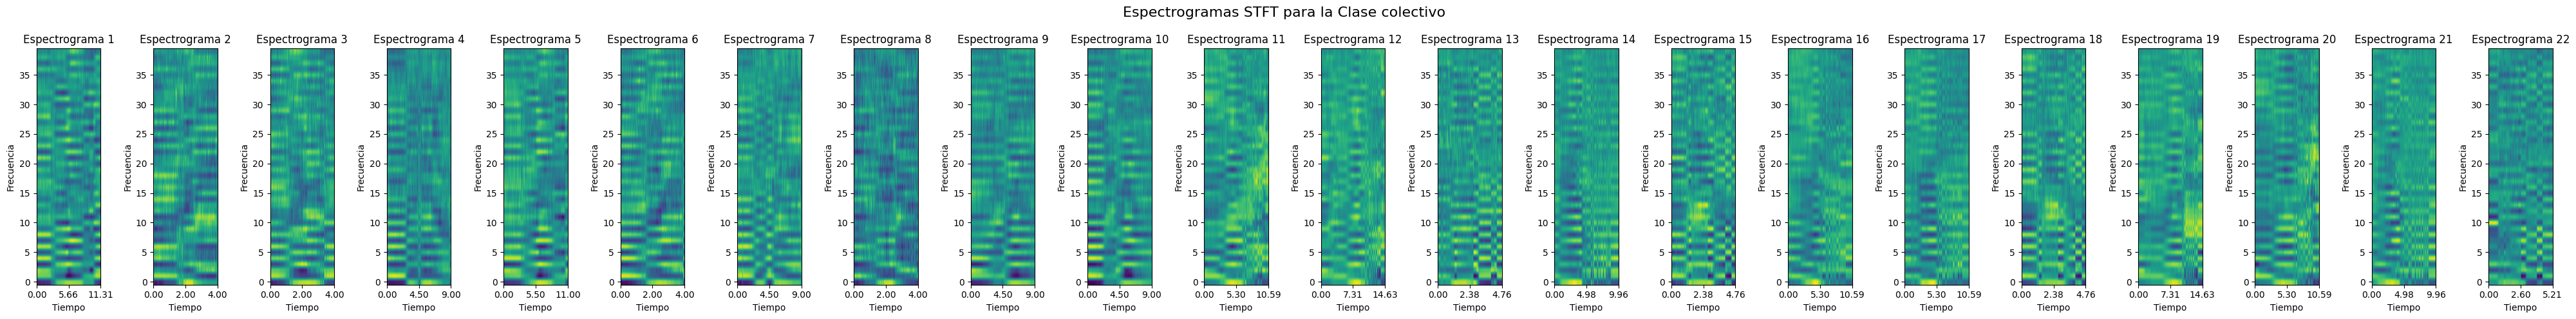

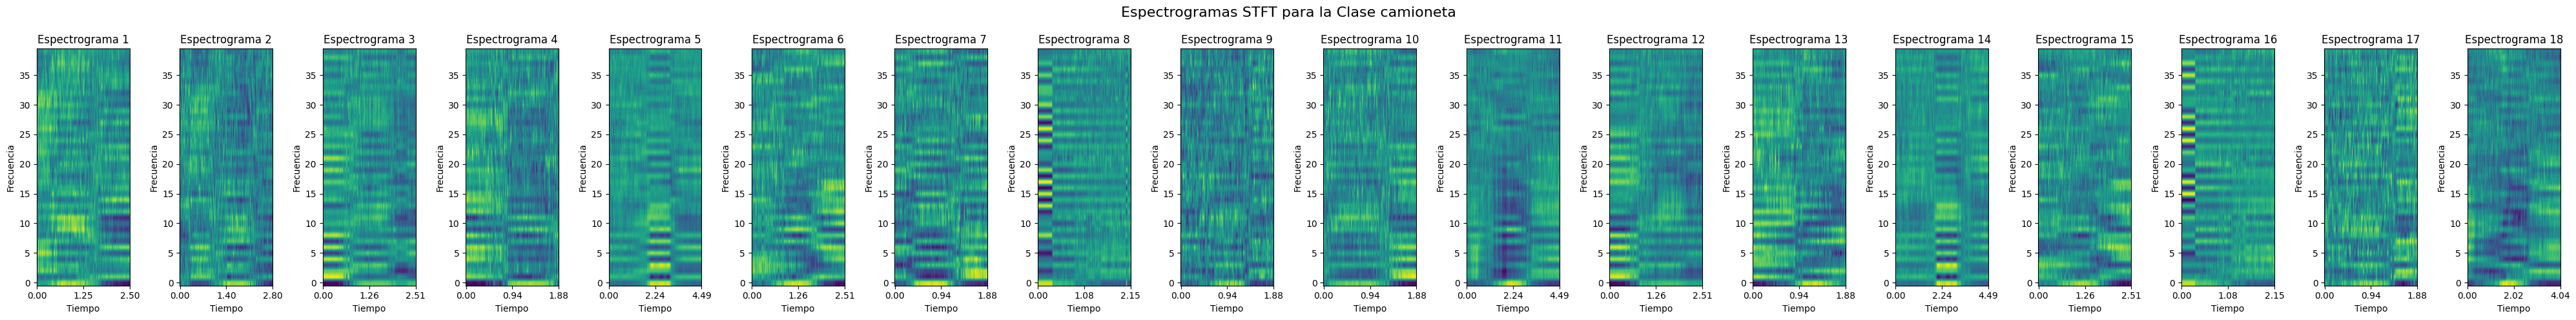

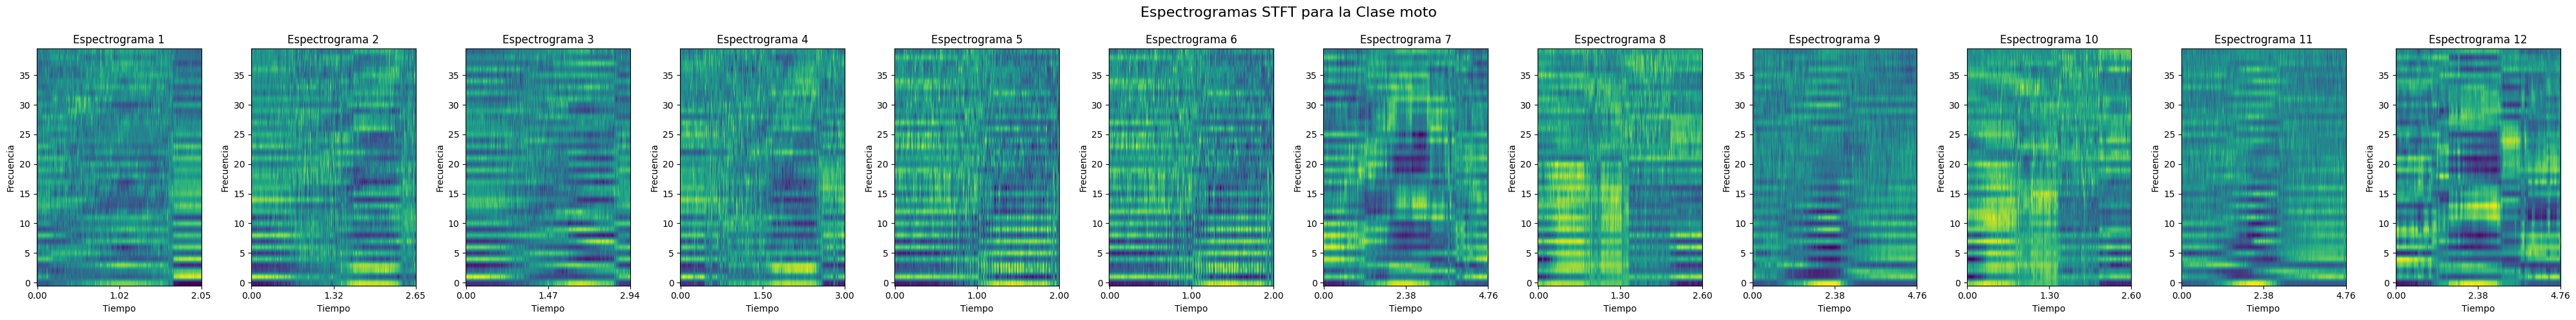

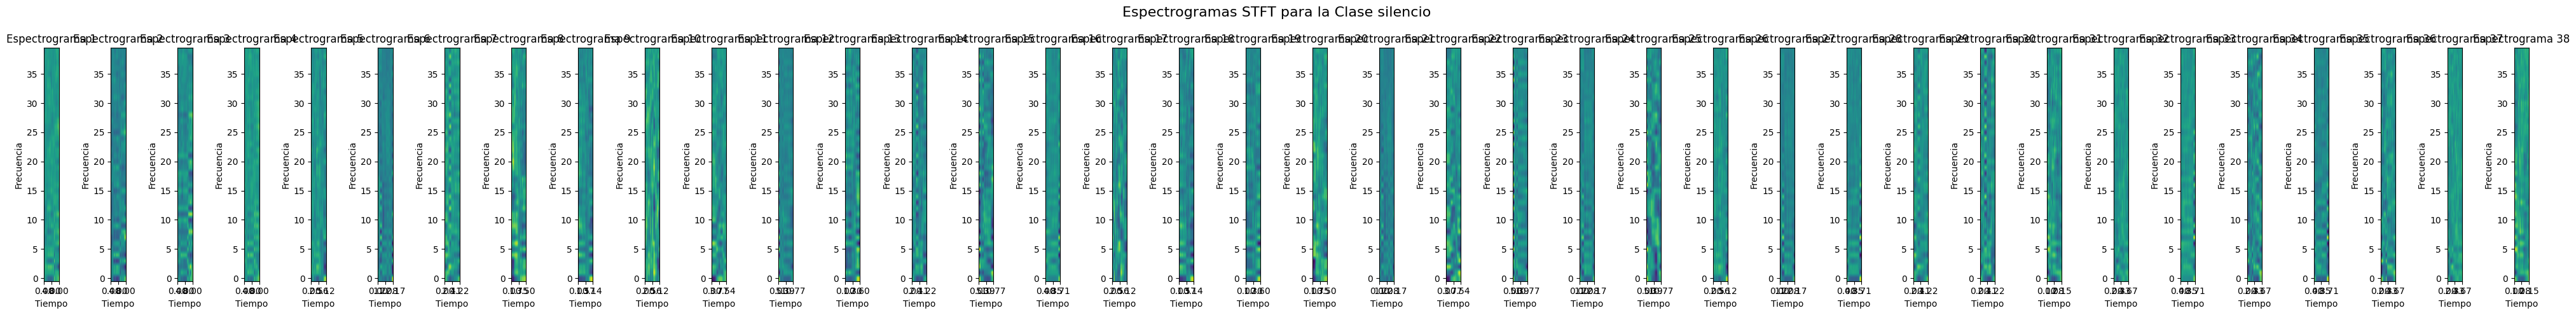

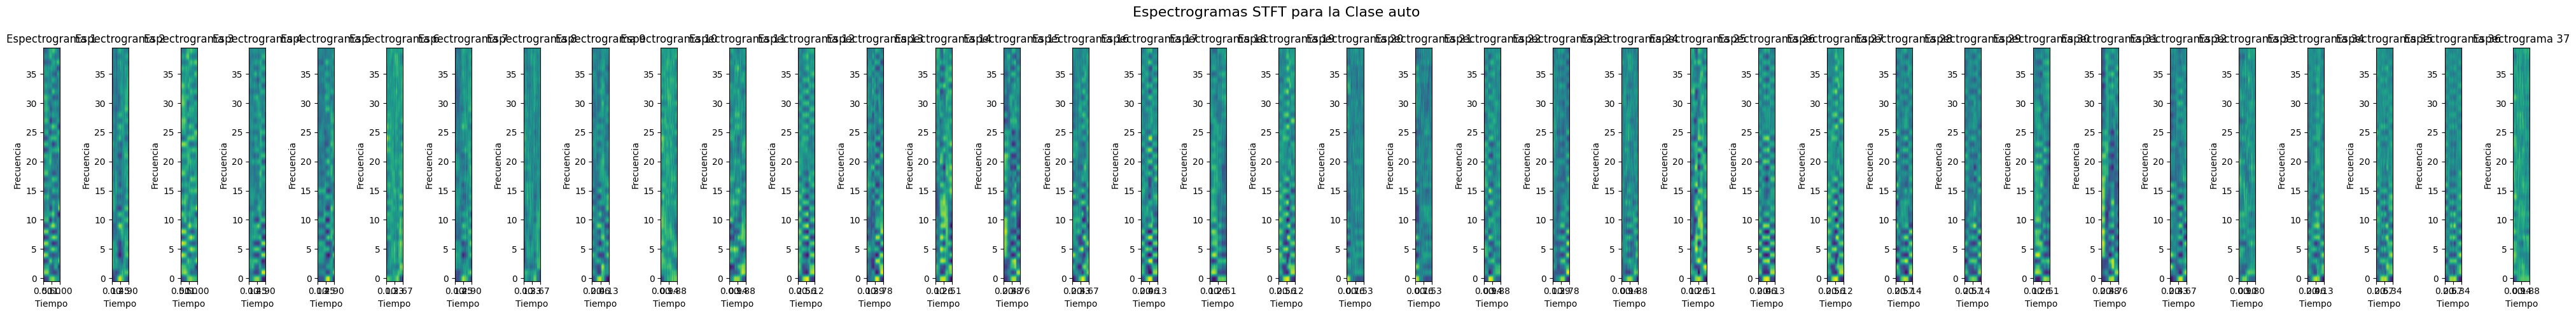

In [179]:

# Tasa de muestreo que vamos a asumir para todos los audios
sampling_rate = 48000
n_fft=1024
hop_length=512
n_mfcc=40

def compute_stft_spectrogram(audio_array, sampling_rate, n_fft, hop_length, n_mfcc):
    """
    Computar los coeficientes MFCC para un array de audio dado y normalizar el espectrograma.

    Args:
    - audio_array (np.ndarray): Array que contiene datos de audio.
    - sampling_rate (int): Frecuencia de muestreo del archivo de audio.
    - n_fft (int): Longitud de la ventana FFT.
    - hop_length (int): Número de muestras entre fotogramas sucesivos.
    - n_mfcc (int): Número de MFCCs a devolver.

    Returns:
    - mfccs (np.ndarray): Representación MFCC normalizada del audio.
    """
    # Computar los MFCCs
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

    # Normalizar los MFCCs
    mfccs_norm = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-6)

    # Opcionalmente, aplicar un filtro de suavizado a los MFCCs para resaltar las características
    mfccs_smoothed = librosa.decompose.nn_filter(mfccs_norm, aggregate=np.median, metric='cosine')

    return mfccs_smoothed



# Diccionario para almacenar los espectrogramas STFT
stft_spectrograms = {}

# Calcular los espectrogramas STFT para cada clase y cada archivo de audio
for k, v in data.items():
    stft_spectrograms[k] = []
    for audio_array in v:
        stft_spec = compute_stft_spectrogram(audio_array, sampling_rate, n_fft, hop_length, n_mfcc)
        stft_spectrograms[k].append(stft_spec)

# Verificar la cantidad de espectrogramas calculados por clase
for k, v in stft_spectrograms.items():
    print(f'Clase {k}: {len(v)} espectrogramas STFT')

# Función para graficar los espectrogramas STFT de una clase específica
def plot_stft_spectrograms(stft_spectrograms, class_name, sr):
    num_specs = len(stft_spectrograms[class_name])
    fig, axs = plt.subplots(1, num_specs, figsize=(40, 5))
    fig.suptitle(f'Espectrogramas STFT para la Clase {class_name}', fontsize=16)

    for i, stft_spec in enumerate(stft_spectrograms[class_name]):
        img = axs[i].imshow(stft_spec, cmap='viridis', origin='lower', aspect='auto')
        axs[i].set_title(f'Espectrograma {i + 1}')
        axs[i].set_xlabel('Tiempo')
        axs[i].set_ylabel('Frecuencia')

        # Calcular marcas de tiempo
        num_time_bins = stft_spec.shape[1]
        duration = len(data[class_name][i]) / sr
        time_ticks = np.linspace(0, duration, num_time_bins)

        # Configurar las marcas de tiempo en el eje x
        axs[i].set_xticks(np.linspace(0, num_time_bins, 3))
        axs[i].set_xticklabels([f'{t:.2f}' for t in np.linspace(0, duration, 3)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustar el espacio para el título
    plt.show()

# Graficar los espectrogramas STFT para cada clase
for class_name in stft_spectrograms.keys():
    plot_stft_spectrograms(stft_spectrograms, class_name, sampling_rate)


##Resumen
#Computar MFCCs: Calcula los coeficientes MFCC del audio.
#Normalizar MFCCs: Resta la media y divide por la desviación estándar para que los datos tengan una distribución más uniforme.
#Suavizar MFCCs: Aplica un filtro de vecinos más cercanos para resaltar las características importantes y reducir el ruido.
#Devolver MFCCs: Devuelve los MFCCs suavizados y normalizados.
Este proceso ayuda a transformar los datos de audio en una representación que es más fácil de analizar y procesar para tareas de reconocimiento y clasificación.


In [180]:
for class_name, spectrogram_list in stft_spectrograms.items():
    for idx, spectrogram in enumerate(spectrogram_list):
        print(f'Dimensiones del espectrograma para la clase {class_name}, índice {idx}: {spectrogram.shape}')

Dimensiones del espectrograma para la clase colectivo, índice 0: (40, 1061)
Dimensiones del espectrograma para la clase colectivo, índice 1: (40, 376)
Dimensiones del espectrograma para la clase colectivo, índice 2: (40, 376)
Dimensiones del espectrograma para la clase colectivo, índice 3: (40, 844)
Dimensiones del espectrograma para la clase colectivo, índice 4: (40, 1032)
Dimensiones del espectrograma para la clase colectivo, índice 5: (40, 376)
Dimensiones del espectrograma para la clase colectivo, índice 6: (40, 844)
Dimensiones del espectrograma para la clase colectivo, índice 7: (40, 376)
Dimensiones del espectrograma para la clase colectivo, índice 8: (40, 844)
Dimensiones del espectrograma para la clase colectivo, índice 9: (40, 844)
Dimensiones del espectrograma para la clase colectivo, índice 10: (40, 993)
Dimensiones del espectrograma para la clase colectivo, índice 11: (40, 1372)
Dimensiones del espectrograma para la clase colectivo, índice 12: (40, 446)
Dimensiones del esp

# PASAMOS LOS ESPECTOGRAMAS A TENSORES PARA ARMAR EL DATASET

In [181]:
# 'men' contiene 'tiempo' que queremos de los espectrogramas
men = 2078# Ajusta la longitud esta en centisegunos creo... hay que revisar

# Convertir los espectrogramas de Mel a tensores de PyTorch
mel_tensor_list = []
labels_list = []

# Iterar sobre las clases y los espectrogramas de Mel correspondientes
for label, mel_specs in stft_spectrograms.items():
    for mel_spec in mel_specs:
        # Asegurarse de que todos los espectrogramas tengan la misma forma (128, men)
        if mel_spec.shape[1] > men:
            mel_spec = mel_spec[:, :men]  # Recortar si es más largo
        elif mel_spec.shape[1] < men:
            mel_spec = np.pad(mel_spec, ((0, 0), (0, men - mel_spec.shape[1])), mode='constant')  # Rellenar si es más corto

        mel_tensor = torch.tensor(mel_spec).unsqueeze(0).float()  # Convertir y añadir dimensión de canal
        mel_tensor_list.append(mel_tensor)
        labels_list.append(label)

# Convertir la lista de etiquetas a tensores de PyTorch
labels_tensor = torch.tensor([list(stft_spectrograms.keys()).index(label) for label in labels_list])

# Crear un Dataset de PyTorch
dataset = TensorDataset(torch.stack(mel_tensor_list), labels_tensor)


In [182]:
print(labels_tensor)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4])


In [183]:
print(labels_list)

['colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'colectivo', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'camioneta', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'moto', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio', 'silencio',

## GRAFICAMOS UN ESPECTOGRAMA CUALQUIERA YA RECORTADO O RELLENADO

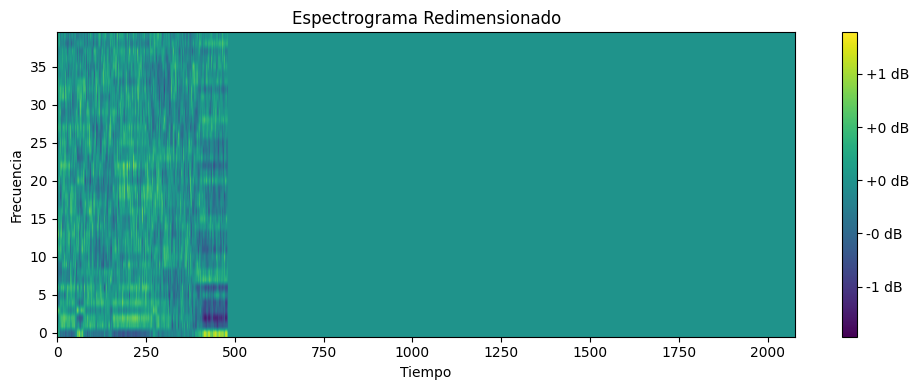

In [184]:
# Seleccionar un espectrograma de Mel para graficar
mel_spec_to_plot = mel_tensor_list[56].squeeze().numpy()  # Convertir de tensor a numpy y eliminar la dimensión del canal

# Graficar el espectrograma de Mel
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_to_plot, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Redimensionado')
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## COMPROBAMOS LAS DIMENSIONES DE LA IMAGEN

In [185]:
# Acceder a un solo elemento del dataset (por ejemplo, el primer elemento)
sample_image, sample_label = dataset[0]

# Inspeccionar las dimensiones del tensor de la imagen
print("Dimensiones de la imagen:", sample_image.size())

# Inspeccionar las dimensiones del tensor de etiquetas
print("Dimensiones de la etiqueta:", sample_label.size())

Dimensiones de la imagen: torch.Size([1, 40, 2078])
Dimensiones de la etiqueta: torch.Size([])


## SEPARAMOS EN TRAIN Y VAL

In [186]:
from torch.utils.data import random_split

# Definir el tamaño del conjunto de entrenamiento y validación
train_size = int(0.8 * len(dataset))  # Usaremos el 80% para entrenamiento
val_size = len(dataset) - train_size  # El restante para validación

# Dividir el dataset en conjuntos de entrenamiento y validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Opcionalmente, puedes imprimir el tamaño de cada conjunto para verificar
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")


Tamaño del conjunto de entrenamiento: 101
Tamaño del conjunto de validación: 26


## DATALOADERS

In [187]:
from torch.utils.data import DataLoader# no es necesario el data loader pero yo lo dejo apra tener un codigo general guardado

# Definir el tamaño del lote (batch size)
batch_size = 32  # Puedes ajustar este valor según la memoria disponible y el tamaño de tu dataset

# Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Crear DataLoader para el conjunto de validación
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## MODELO

In [188]:
import torch
import torch.nn as nn

# Definición del modelo
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Salida de conv1: [1, 16, 40, 354] (16 canales, cada uno de tamaño 40x354)

        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Salida de maxpool1: [1, 16, 20, 177] (tamaño reducido a la mitad en ambas dimensiones)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Salida de conv2: [1, 32, 20, 177] (32 canales, cada uno de tamaño 20x177)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Salida de maxpool2: [1, 32, 10, 88] (tamaño reducido a la mitad en ambas dimensiones)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Salida de conv3: [1, 64, 10, 88] (64 canales, cada uno de tamaño 10x88)

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Salida de maxpool3: [1, 64, 5, 44] (tamaño reducido a la mitad en ambas dimensiones)

        self.dropout = nn.Dropout(p=0.5)

        # LSTM como codificador
        self.input_size = 64 * (40 // 8) * (2078 // 8)  # Ajustar según las dimensiones de entrada
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=128,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        # Salida de LSTM: [1, 256] (128 unidades ocultas bidireccionales, ya que es LSTM bidireccional)

        # Decoder
        self.fc1 = nn.Linear(2 * 128, 128)
        # Salida de fc1: [1, 128] (128 neuronas)

        self.fc2 = nn.Linear(128, 64)
        # Salida de fc2: [1, 64] (64 neuronas)

        self.fc3 = nn.Linear(64, num_classes)  # Cambiar el tamaño de salida a num_classes
        # Salida de fc3: [1, num_classes] (num_classes neuronas, donde num_classes es el número de categorías)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.dropout(x)

        # Preparar para LSTM
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)

        # LSTM como codificador
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]

        # Decoder
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x


modelo SimpleCNN en una estructura de Autoencoder, donde las dimensiones se van achicando y luego se van expandiendo, puedes seguir este enfoque:

Encoder:

Utilizarás las capas convolucionales (conv1, conv2, conv3) para reducir progresivamente las dimensiones de entrada.
No necesitarás las capas completamente conectadas (fc1, fc2, fc3) en el encoder, ya que el autoencoder se basa en la representación latente aprendida por las capas convolucionales.
Decoder:

Después de la capa LSTM en tu modelo actual, necesitarás una serie de capas deconvolucionales (también conocidas como capas transpuestas convolucionales) para reconstruir la entrada original a partir de la representación latente generada por el LSTM.
Estas capas deconvolucionales expandirán progresivamente las dimensiones de la entrada latente.
Aquí tienes una versión modificada de tu modelo SimpleCNN

## INSTANCIAMOS EL MODELO

In [189]:
# Definir hiperparámetros
learning_rate = 0.001 # no es necesario con adadelta
num_epochs = 150

# Crear una instancia del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=5).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = optim.Adadelta(model.parameters())

## FUNCION DE ENTRENAMIENTO

In [190]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Ajustar las dimensiones de las etiquetas
            labels = labels.squeeze().long()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            # Calcular precisión de entrenamiento
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train_preds / total_train_preds

        # Modo de evaluación
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                # Ajustar las dimensiones de las etiquetas
                labels = labels.squeeze().long()

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Calcular precisión de validación
                _, predicted = torch.max(outputs, 1)
                correct_val_preds += (predicted == labels).sum().item()
                total_val_preds += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val_preds / total_val_preds
        val_accuracies.append(val_accuracy)

        # Imprimir métricas del epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Graficar las curvas de pérdida y precisión en validación
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(np.arange(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, val_accuracies


## ENTRENAMIENTO

In [ ]:
# Entrenar el modelo
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/150], Train Loss: 1.6072, Train Acc: 0.1881, Val Loss: 1.5945, Val Acc: 0.3077


## PREDICCION

In [173]:
import random

# Función para hacer una predicción aleatoria en el conjunto de validación
def predict_random_sample(model, val_loader):
    model.eval()
    model = model.to(device)

    # Seleccionar un índice aleatorio del conjunto de validación
    random_idx = random.randint(0, len(val_loader.dataset) - 1)
    random_sample = val_loader.dataset[random_idx]

    # Obtener las entradas y etiquetas del lote
    inputs, label = random_sample

    # Si es necesario, ajustar la forma de las entradas para que se ajuste al modelo
    inputs = inputs.unsqueeze(0)  # Añadir una dimensión de lote

    # Mover las entradas a la GPU si está disponible
    inputs = inputs.to(device)

    # Hacer la predicción
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Imprimir la etiqueta verdadera y la predicción
    print(f'Etiqueta verdadera: {label.item()}, Predicción: {predicted.item()}')
    print(f'tensor:{outputs}')

In [178]:
predict_random_sample(model, val_loader)


Etiqueta verdadera: 0, Predicción: 0
tensor:tensor([[ 11.5771, -35.8549, -11.2739,  -8.5389,  -2.6782]])


In [156]:
from sklearn.metrics import confusion_matrix


model.eval()  # Poner el modelo en modo de evaluación

predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
cm = confusion_matrix(true_labels, predictions)

# Interpretar la matriz de confusión
TN = cm[0, 0]  # Verdaderos negativos
FP = cm[0, 1]  # Falsos positivos
FN = cm[1, 0]  # Falsos negativos
TP = cm[1, 1]  # Verdaderos positivos

print("Matriz de Confusión:")
print(cm)
print(f"Verdaderos Negativos: {TN}")
print(f"Falsos Positivos: {FP}")
print(f"Falsos Negativos: {FN}")
print(f"Verdaderos Positivos: {TP}")


NameError: name 'test_loader' is not defined